In [639]:
# %pip install pmdarima
# %pip install arch

In [640]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

In [641]:
#data = pd.read_csv("mol_d.csv", usecols=['Data', 'Zamkniecie'])
data = pd.read_csv("mol_d.csv")
df = pd.DataFrame(data)
df_copy = df.copy()
display(df)

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,2023-09-01,29.3472,29.3472,28.6122,28.6489,876.120358
1,2023-09-04,28.6673,28.9797,28.6489,28.7959,638.860435
2,2023-09-05,28.6857,28.9797,28.5387,28.9429,1267.925736
3,2023-09-06,28.9981,28.9981,28.4835,28.7592,4692.957746
4,2023-09-07,28.5938,29.4024,26.8664,29.3656,14380.345710
...,...,...,...,...,...,...
267,2024-09-24,28.5200,29.0000,28.5200,28.7400,41614.000000
268,2024-09-25,28.9800,28.9800,28.5400,28.6400,63116.000000
269,2024-09-26,28.7000,28.9800,28.7000,28.7400,1516.000000
270,2024-09-27,29.0000,29.1000,28.8200,29.0400,398.000000


In [642]:
df['Data'] = pd.to_datetime(df['Data'])
df = df.set_index('Data')
df['Stopa zwrotu'] = df['Zamkniecie'].pct_change()
df['Logarytm ceny'] = np.log(df['Zamkniecie'])
df['Logarytm stopy zwrotu'] = np.log(1 + df['Stopa zwrotu'])
display(df)

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Stopa zwrotu,Logarytm ceny,Logarytm stopy zwrotu
Data,,,,,,,,
2023-09-01,29.3472,29.3472,28.6122,28.6489,876.120358,NaN,3.355115,NaN
2023-09-04,28.6673,28.9797,28.6489,28.7959,638.860435,0.005131,3.360233,0.005118
2023-09-05,28.6857,28.9797,28.5387,28.9429,1267.925736,0.005105,3.365325,0.005092
2023-09-06,28.9981,28.9981,28.4835,28.7592,4692.957746,-0.006347,3.358958,-0.006367
2023-09-07,28.5938,29.4024,26.8664,29.3656,14380.345710,0.021085,3.379824,0.020866
...,...,...,...,...,...,...,...,...
2024-09-24,28.5200,29.0000,28.5200,28.7400,41614.000000,0.007714,3.358290,0.007684
2024-09-25,28.9800,28.9800,28.5400,28.6400,63116.000000,-0.003479,3.354804,-0.003486
2024-09-26,28.7000,28.9800,28.7000,28.7400,1516.000000,0.003492,3.358290,0.003486


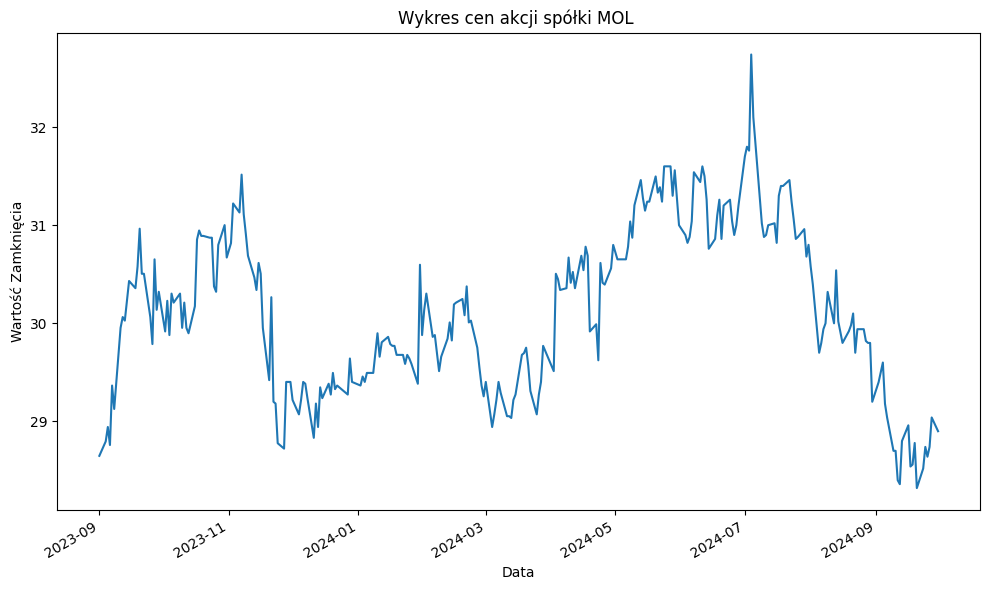

In [643]:
df['Zamkniecie'].plot(title="Wykres cen akcji spółki MOL ", figsize=(10, 6), ylabel="Wartość Zamknięcia")
plt.tight_layout()
plt.show()

In [644]:
fig = go.Figure(data = [go.Candlestick(x=df_copy['Data'],
                                       open=df_copy['Otwarcie'],
                                       high=df_copy['Najwyzszy'],
                                       low=df_copy['Najnizszy'],
                                       close=df_copy['Zamkniecie'])])


fig.update_layout(xaxis_rangeslider_visible = False)
fig.update_layout(yaxis_title = "Cena", xaxis_title = "Data", title = 'Wykres cen akcji spółki MOL')
fig.update_layout(height=800, width=1500)
fig.update_yaxes(type="log")

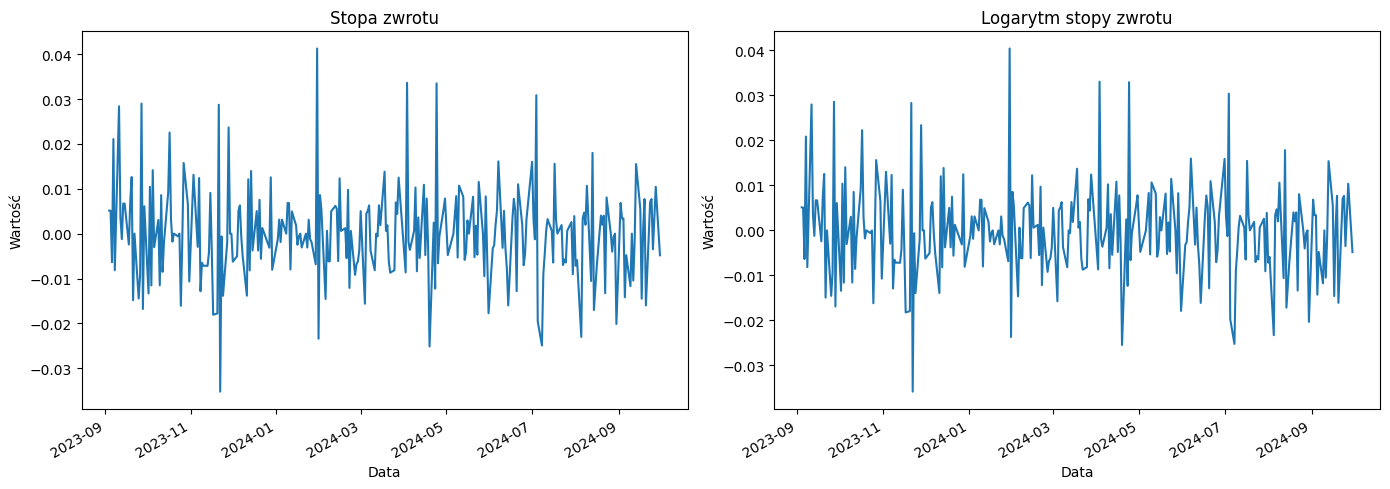

In [645]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['Stopa zwrotu'].plot(ax=axes[0], title="Stopa zwrotu")
df['Logarytm stopy zwrotu'].plot(ax=axes[1], title="Logarytm stopy zwrotu")
df = df.iloc[1:]

for ax in axes:
    ax.set_xlabel("Data")
    ax.set_ylabel("Wartość")

plt.tight_layout()
plt.show()

# 1. Badanie stacjonarności stóp zwrotu i logarytmów cen (test ADF)

In [646]:
# badanie stacjonarności stóp zwrotu
# Test ADF
adf_result = adfuller(df['Logarytm stopy zwrotu'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -21.316896889799263
p-value: 0.0


p-value < 0.05 więc odrzucamy H0 i szereg jest stacjonarny

In [647]:
# badanie stacjonarności logarytmów cen
adf_result = adfuller(df['Logarytm ceny'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -2.3847079872608545
p-value: 0.14609906305448278


p-value > 0.05 więc zostawiamy H0 i szereg jest niestacjonarny

# 2. Dopasowanie modelu

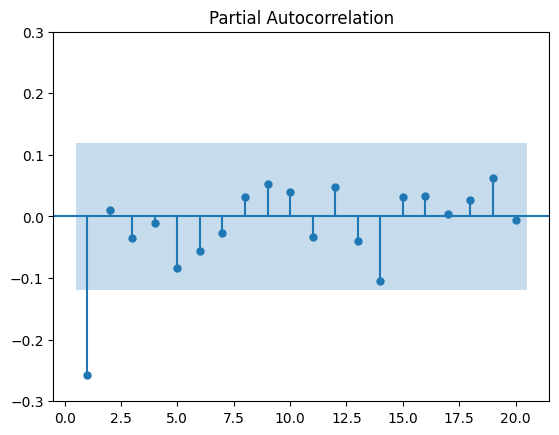

<Figure size 640x480 with 0 Axes>

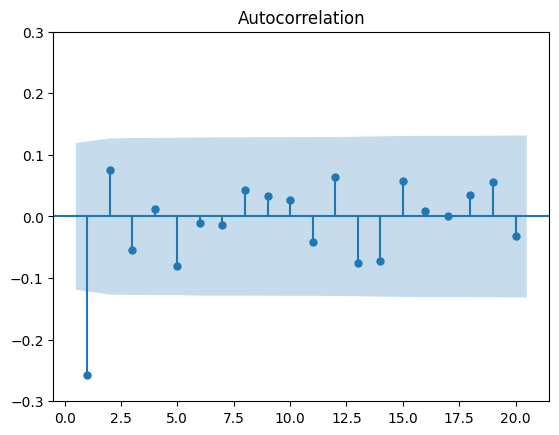

In [648]:

plot_pacf(df['Logarytm stopy zwrotu'], lags=20, zero=False)
plt.ylim(-0.3, 0.3)

plt.figure()
plot_acf(df['Logarytm stopy zwrotu'], lags=20, zero=False)
plt.ylim(-0.3, 0.3)

plt.show()

In [649]:
# Użycie auto_arima do automatycznego wyboru optymalnych parametrów
stepwise_model_st_zwrotu = auto_arima(df['Logarytm stopy zwrotu'], start_p=0, start_q=0,
                            max_p=5, max_q=5,
                            seasonal=False,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model_st_zwrotu.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1713.139, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1729.738, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1728.598, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1727.765, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1727.775, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1725.745, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1727.742, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.301 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  271
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 866.869
Date:                Sun, 03 Nov 2024   AIC                          -1729.738
Time:                        21:20:45   BIC                          -1722.533
Sample:         

więc robimy ARME

In [650]:
# Użycie auto_arima do automatycznego wyboru optymalnych parametrów
stepwise_model_st_zwrotu = auto_arima(df['Logarytm ceny'], start_p=0, start_q=0,
                            max_p=5, max_q=5,
                            seasonal=False,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model_st_zwrotu.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1704.063, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1720.765, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1719.634, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1706.062, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1718.801, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1718.803, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1716.775, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1722.765, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1720.800, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1720.802, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1721.629, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1718.774, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.717 seconds
                               SARIMAX Results                              

In [651]:
def plot_price_prediction(predicted_prices, upper_bounds, lower_bounds, title):
    historical_data = pd.read_csv('mol_d.csv', parse_dates=['Data'])
    actual_data = pd.read_excel('mol_d_pazdziernik_stopy.xlsx', parse_dates=['Data'])

    historical_data = historical_data[historical_data['Data'] >= '2024-09-01']

    predicted_dates = pd.date_range(start=historical_data['Data'].iloc[-1] + pd.Timedelta(days=1), periods=4, freq='D')

    plt.figure(figsize=(12, 6))

    plt.plot(historical_data['Data'], historical_data['Zamkniecie'], label='Historical Price', color='blue')

    plt.plot(actual_data['Data'], actual_data['Zamkniecie'], label='Actual Price', color='black', marker='o')

    plt.plot(predicted_dates, predicted_prices, label='Predicted Price', color='orange', linestyle='--', marker='x')

    plt.fill_between(predicted_dates, lower_bounds, upper_bounds, color='orange', alpha=0.3, label='Prediction Interval')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    plt.xticks(rotation=45)


    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 2. Budowanie modelu

In [652]:
model_log_st = ARIMA(df['Logarytm stopy zwrotu'], order=(1, 0, 0)).fit()
print(model_log_st.summary())

                                 SARIMAX Results                                 
Dep. Variable:     Logarytm stopy zwrotu   No. Observations:                  271
Model:                    ARIMA(1, 0, 0)   Log Likelihood                 866.871
Date:                   Sun, 03 Nov 2024   AIC                          -1727.742
Time:                           21:20:46   BIC                          -1716.936
Sample:                                0   HQIC                         -1723.403
                                   - 271                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.89e-05      0.000      0.059      0.953      -0.001       0.001
ar.L1         -0.2580      0.053     -4.891      0.000      -0.361      -0.155
sigma2      9.751e-05   6.53

In [653]:
model_log = ARIMA(df['Logarytm ceny'], order=(1, 1, 0)).fit()
print(model_log.summary())

                               SARIMAX Results                                
Dep. Variable:          Logarytm ceny   No. Observations:                  271
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 863.382
Date:                Sun, 03 Nov 2024   AIC                          -1722.765
Time:                        21:20:46   BIC                          -1715.568
Sample:                             0   HQIC                         -1719.875
                                - 271                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2591      0.053     -4.932      0.000      -0.362      -0.156
sigma2       9.77e-05   6.46e-06     15.117      0.000     8.5e-05       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [654]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(model_log.resid, lags=20)
print("Ljung-Box test for autocorrelation in residuals:")
print(lb_test)

Ljung-Box test for autocorrelation in residuals:
     lb_stat  lb_pvalue
1   0.000618   0.980167
2   0.001254   0.999373
3   0.009900   0.999739
4   0.010128   0.999987
5   0.025562   0.999994
6   0.028327   1.000000
7   0.028332   1.000000
8   0.029447   1.000000
9   0.031334   1.000000
10  0.031346   1.000000
11  0.032311   1.000000
12  0.037653   1.000000
13  0.041693   1.000000
14  0.042306   1.000000
15  0.047757   1.000000
16  0.052338   1.000000
17  0.069250   1.000000
18  0.071725   1.000000
19  0.071780   1.000000
20  0.076088   1.000000


Jeśli p-value jest > 0.05 to nie ma podstaw do odrzucania H0, oznacza to, że nie ma istotnej autokorelacji w resztach dla badanych opóźnień co sugeruje, że model jest prawidłowy.

In [655]:
from scipy.stats import jarque_bera

jb_test = jarque_bera(model_log.resid)
print("Jarque-Bera test for normality of residuals:")
print(jb_test)

Jarque-Bera test for normality of residuals:
SignificanceResult(statistic=803460.2028333963, pvalue=0.0)


p-value < 0.05 co oznacza, że odrzucamy H0 mówiące o normalności rozkładu reszt.

# 3. Wyznaczanie prognoz

In [656]:
# Prognozowanie ARMA logarytmicznych stóp zwrotu
forecast_arima = model_log_st.get_forecast(steps=4)
forecast_arima_df = forecast_arima.conf_int(alpha=0.05)
forecast_arima_df['Point Forecast'] = forecast_arima.predicted_mean
forecast_arima_df['Lower Bound'] = forecast_arima_df.iloc[:, 0]
forecast_arima_df['Upper Bound'] = forecast_arima_df.iloc[:, 1]
print(forecast_arima_df)

     lower Logarytm stopy zwrotu  upper Logarytm stopy zwrotu  Point Forecast  \
271                    -0.018071                     0.020637        0.001283   
272                    -0.020283                     0.019693       -0.000295   
273                    -0.019917                     0.020142        0.000112   
274                    -0.020025                     0.020039        0.000007   

     Lower Bound  Upper Bound  
271    -0.018071     0.020637  
272    -0.020283     0.019693  
273    -0.019917     0.020142  
274    -0.020025     0.020039  


In [657]:
# Prognozowanie ARIMA cen logarytmicznych
forecast_arima_log_prices = model_log.get_forecast(steps=4)
forecast_arima_log_prices_df = forecast_arima_log_prices.conf_int(alpha=0.05)
forecast_arima_log_prices_df['Point Forecast'] = forecast_arima_log_prices.predicted_mean
forecast_arima_log_prices_df['Lower Bound'] = forecast_arima_log_prices_df.iloc[:, 0]
forecast_arima_log_prices_df['Upper Bound'] = forecast_arima_log_prices_df.iloc[:, 1]
forecast_arima_log_prices_df = forecast_arima_log_prices_df.reset_index(drop=True)
forecast_arima_log_prices.predicted_mean = forecast_arima_log_prices.predicted_mean.reset_index(drop=True)
print(forecast_arima_log_prices_df)

   lower Logarytm ceny  upper Logarytm ceny  Point Forecast  Lower Bound  \
0             3.345721             3.384467        3.365094     3.345721   
1             3.340659             3.388880        3.364769     3.340659   
2             3.336107             3.393600        3.364854     3.336107   
3             3.332260             3.397404        3.364832     3.332260   

   Upper Bound  
0     3.384467  
1     3.388880  
2     3.393600  
3     3.397404  


In [658]:
alpha = 0.05
u = forecast_arima_log_prices.predicted_mean
u_alpha = scipy.stats.norm.ppf(1 - alpha/2)
print(u_alpha)

sd1 = ((forecast_arima_log_prices.predicted_mean[0]-forecast_arima_log_prices_df["Lower Bound"][0])/u_alpha)
sd2 = ((forecast_arima_log_prices.predicted_mean[1]-forecast_arima_log_prices_df["Lower Bound"][1])/u_alpha)
sd3 = ((forecast_arima_log_prices.predicted_mean[2]-forecast_arima_log_prices_df["Lower Bound"][2])/u_alpha)
sd4 = ((forecast_arima_log_prices.predicted_mean[3]-forecast_arima_log_prices_df["Lower Bound"][3])/u_alpha)

sd = [sd1,sd2,sd3,sd4]
print(sd)

1.959963984540054
[0.009884437630710119, 0.012301501092994768, 0.014666785040655984, 0.016618782999853927]


In [659]:
forecast_prices = [np.exp(u[0] + (sd[0]**2)/2), np.exp(u[1] + (sd[1]**2)/2), np.exp(u[2] + (sd[2]**2)/2), np.exp(u[3] + (sd[3]**2)/2)]
print(forecast_prices)


[28.93762952502089, 28.929015040447545, 28.932371004645923, 28.932623834897342]


In [660]:
lower_bound = [np.exp(forecast_arima_log_prices_df['Lower Bound'][i]) for i in range(0,4)]
upper_bound = [np.exp(forecast_arima_log_prices_df['Upper Bound'][i]) for i in range(0,4)]

print("95% przedział ufności dla prognozowanych cen:")
for i in range(4):
  print(f"Dzień {i+1}: {lower_bound[i]:.4f} - {upper_bound[i]:.4f}")

95% przedział ufności dla prognozowanych cen:
Dzień 1: 28.3810 - 29.5023
Dzień 2: 28.2377 - 29.6327
Dzień 3: 28.1095 - 29.7729
Dzień 4: 28.0015 - 29.8864


In [661]:
# Create a DataFrame
confidence_intervals_df = pd.DataFrame({
    'Forecast': forecast_prices,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound
})

confidence_intervals_df

,Forecast,Lower Bound,Upper Bound
0,28.937630,28.381026,29.502267
1,28.929015,28.237727,29.632742
2,28.932371,28.109487,29.772939
3,28.932624,28.001540,29.886412


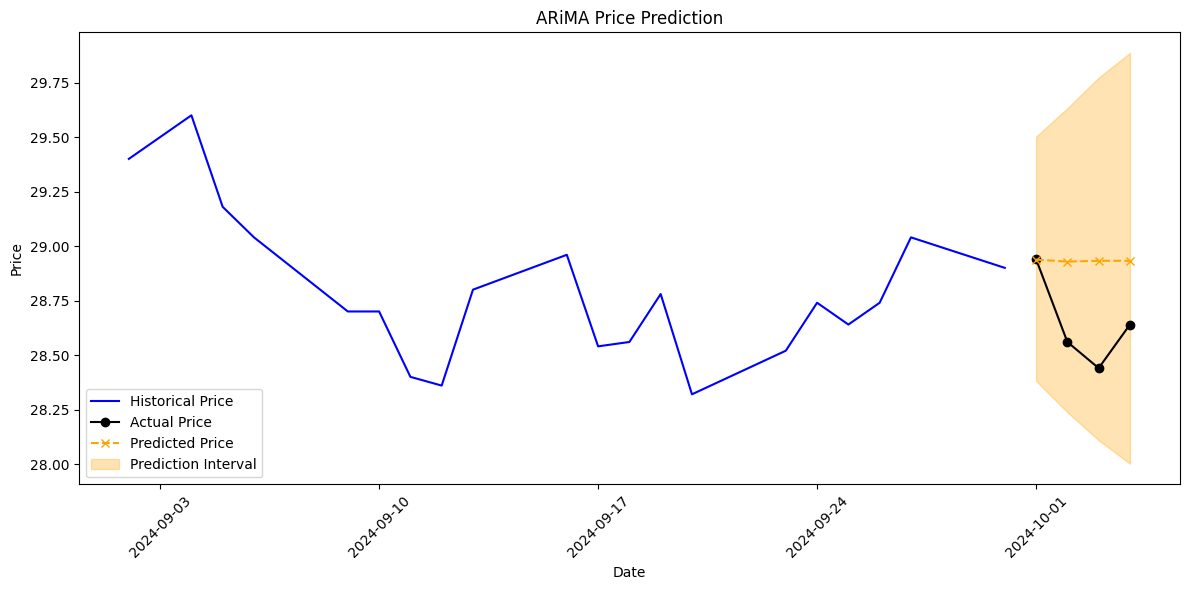

In [662]:
plot_price_prediction(confidence_intervals_df['Forecast'],confidence_intervals_df['Upper Bound'],confidence_intervals_df['Lower Bound'], 'ARiMA Price Prediction')

In [663]:
real_values = pd.read_excel("mol_d_pazdziernik_stopy.xlsx")
forecast_errors = [forecast_prices[i] - real_values["Zamkniecie"][i] for i in range(len(real_values))]

mae = np.mean(np.abs(forecast_errors))
mse = np.mean(np.square(forecast_errors))
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.2890950887424806
Mean Squared Error (MSE): 0.11605890854854788
Root Mean Squared Error (RMSE): 0.340674197068912


# 4. Monte Carlo

In [664]:
model_log = ARIMA(df['Logarytm ceny'], order=(1, 1, 0)).fit()
residuals = model_log.resid
steps = 4  
n_simulations = 1000  
np.random.seed(42)


forecast_results = []
current_data = df['Logarytm ceny'].copy()

for step in range(steps):

    model_log = ARIMA(current_data, order=(1, 1, 0)).fit()

    forecast = model_log.get_forecast(steps=1)
    point_forecast = forecast.predicted_mean.iloc[0]

    simulated_forecasts = np.zeros(n_simulations)

    for i in range(n_simulations):
        simulated_forecasts[i] = point_forecast + np.random.choice(residuals)

    lower_bound = np.percentile(simulated_forecasts, 2.5)
    upper_bound = np.percentile(simulated_forecasts, 97.5)

    forecast_results.append({
        'Point Forecast': point_forecast,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    })

    current_data = pd.concat([current_data, pd.Series([point_forecast])], ignore_index=True)

forecast_monte_carlo_df = pd.DataFrame(forecast_results)
print(forecast_monte_carlo_df)

   Point Forecast  Lower Bound  Upper Bound
0        3.365094     3.348891     3.391290
1        3.364769     3.348999     3.382376
2        3.364854     3.345680     3.394607
3        3.364832     3.348629     3.391027


In [665]:
sd_AG = (forecast_monte_carlo_df['Point Forecast'] - forecast_monte_carlo_df['Lower Bound']) / u_alpha
forecast_monte_carlo_AG_prices = np.exp(forecast_monte_carlo_df['Point Forecast'] + 0.5 * sd_AG**2)
forecast_monte_carlo_AG_prices_df = pd.DataFrame(forecast_monte_carlo_AG_prices, columns=['Point Forecast'])
forecast_monte_carlo_AG_prices_df[['Lower Bound', 'Upper Bound']] = np.exp(forecast_monte_carlo_df[['Lower Bound', 'Upper Bound']])
forecast_monte_carlo_AG_prices_df = forecast_monte_carlo_AG_prices_df.reset_index(drop=True)
print(forecast_monte_carlo_AG_prices_df)

   Point Forecast  Lower Bound  Upper Bound
0       28.937205    28.471137    29.704233
1       28.927763    28.474211    29.440634
2       28.930644    28.379878    29.802945
3       28.929617    28.463672    29.696444


In [ ]:
# np.random.seed(42)
# monte_carlo_log_prices = forecast_monte_carlo_df['Point Forecast']
# monte_carlo_log_prices
# sd_mc1 = (monte_carlo_log_prices - forecast_monte_carlo_df['Lower Bound']) / u_alpha
# forecast_arima_prices = np.exp(monte_carlo_log_prices + 0.5 * sd_mc1**2)
# forecast_arima_prices_df = pd.DataFrame(forecast_arima_prices, columns=['Forecast'])
# forecast_arima_prices_df[['Lower Bound', 'Upper Bound']] = np.exp(forecast_arima_log_prices_df[['Lower Bound', 'Upper Bound']])
# print(forecast_arima_prices_df)

    Forecast  Lower Bound  Upper Bound
0  28.937205    28.381026    29.502267
1  28.927763    28.237727    29.632742
2  28.930644    28.109487    29.772939
3  28.929617    28.001540    29.886412


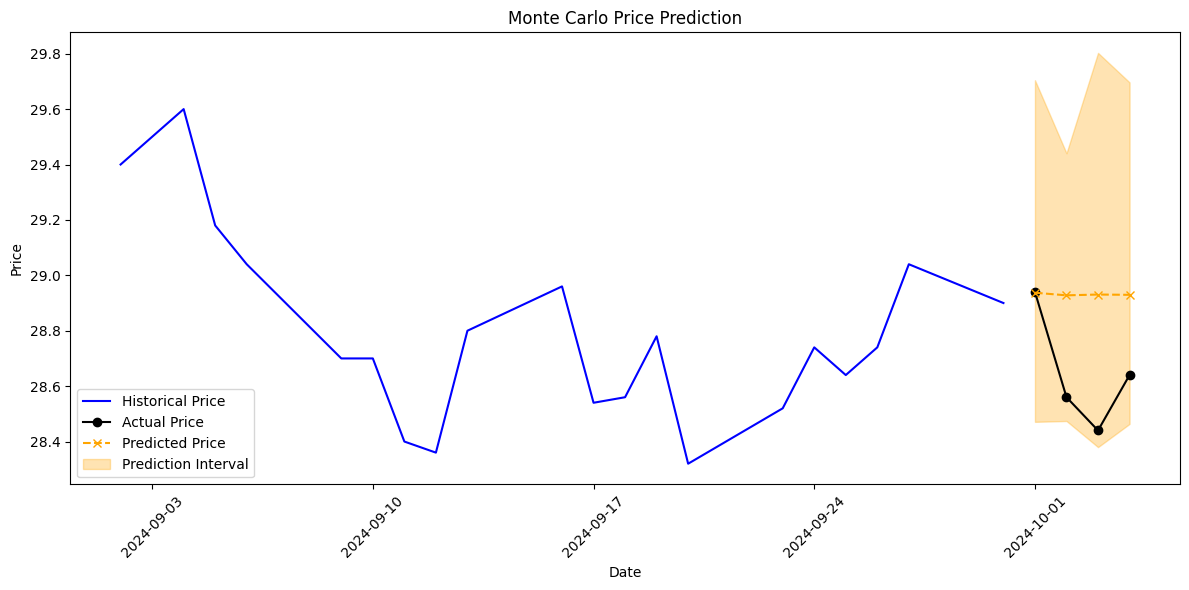

In [619]:
plot_price_prediction(forecast_monte_carlo_AG_prices_df['Point Forecast'],forecast_monte_carlo_AG_prices_df['Upper Bound'],forecast_monte_carlo_AG_prices_df['Lower Bound'], 'Monte Carlo Price Prediction')

In [ ]:
forecast_errors = [forecast_monte_carlo_AG_prices_df['Forecast'][i] - real_values["Zamkniecie"][i] for i in range(len(real_values))]

mae = np.mean(np.abs(forecast_errors))

mse = np.mean(np.square(forecast_errors))

rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.288249616035257
Mean Squared Error (MSE): 0.11571829494357544
Root Mean Squared Error (RMSE): 0.3401739186703993


# 5. Bootstrap


In [621]:
np.random.seed(42)

forecast_results = []
current_data = df['Logarytm ceny'].copy()

for step in range(steps):
    model_log = ARIMA(current_data, order=(1, 1, 0)).fit()

    forecast = model_log.get_forecast(steps=1)
    point_forecast = forecast.predicted_mean.iloc[0]

    simulated_forecasts = np.zeros(n_simulations)

    for i in range(n_simulations):
        bootstrap_residual = np.random.choice(residuals, replace=True)
        simulated_forecasts[i] = point_forecast + bootstrap_residual

    lower_bound = np.percentile(simulated_forecasts, 2.5)
    upper_bound = np.percentile(simulated_forecasts, 97.5)

    forecast_results.append({
        'Point Forecast': point_forecast,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    })

    current_data = pd.concat([current_data, pd.Series([point_forecast])], ignore_index=True)

forecast_bootstrap_df = pd.DataFrame(forecast_results)
print(forecast_bootstrap_df)

   Point Forecast  Lower Bound  Upper Bound
0        3.365094     3.348891     3.391290
1        3.364769     3.348999     3.382376
2        3.364854     3.345680     3.394607
3        3.364832     3.348629     3.391027


In [622]:
sd_mc1 = (forecast_bootstrap_df['Upper Bound'] - forecast_bootstrap_df['Point Forecast']) / u_alpha

forecast_arima_prices = np.exp(forecast_bootstrap_df['Point Forecast'] + 0.5 * sd_mc1**2)

forecast_arima_prices_df = pd.DataFrame({
    'Forecast': forecast_arima_prices,
    'Lower Bound': np.exp(forecast_bootstrap_df['Lower Bound']),
    'Upper Bound': np.exp(forecast_bootstrap_df['Upper Bound'])
})

print(forecast_arima_prices_df)

    Forecast  Lower Bound  Upper Bound
0  28.938801    28.471137    29.704233
1  28.927993    28.474211    29.440634
2  28.932593    28.379878    29.802945
3  28.931213    28.463672    29.696444


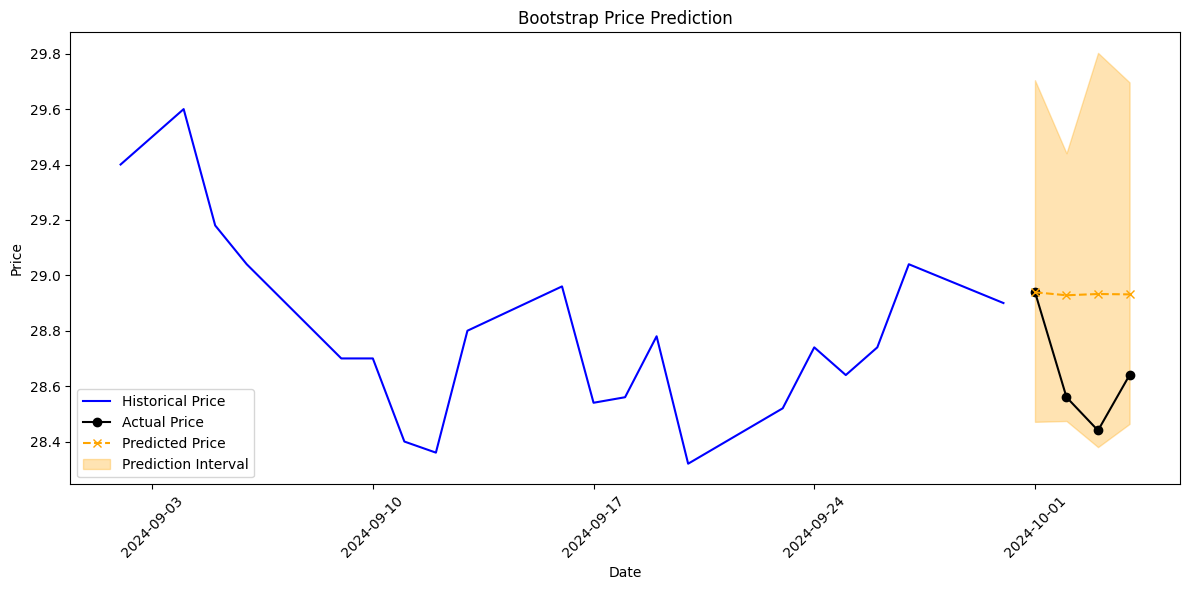

In [623]:
plot_price_prediction(forecast_arima_prices_df['Forecast'],forecast_arima_prices_df['Upper Bound'],forecast_arima_prices_df['Lower Bound'], 'Bootstrap Price Prediction')

In [624]:
forecast_errors = [forecast_arima_prices_df['Forecast'][i] - real_values["Zamkniecie"][i] for i in range(len(real_values))]

mae = np.mean(np.abs(forecast_errors))

mse = np.mean(np.square(forecast_errors))

rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.288249616035257
Mean Squared Error (MSE): 0.11571829494357544
Root Mean Squared Error (RMSE): 0.3401739186703993


# 6. Garch

In [625]:

residuals_st = model_log_st.resid

# ARMA(1,0,0)-GARCH(1,1) model
model_arma_garch = arch_model(residuals_st, vol='Garch', p=1, q=1)
results_garch = model_arma_garch.fit(disp='off')

arima_forecast = model_log_st.forecast(steps=4)
garch_forecast = results_garch.forecast(horizon=4)

forecast_values = arima_forecast + garch_forecast.mean.values[-1, :]

std_dev = np.sqrt(garch_forecast.variance.values[-1, :])

ci_lower = forecast_values - 1.96 * std_dev  
ci_upper = forecast_values + 1.96 * std_dev  

forecast_values_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower Bound': ci_lower,
    'Upper Bound': ci_upper
})

print("ARIMA-GARCH Forecasts for the next 4 periods:")
print(forecast_values_df)

ARIMA-GARCH Forecasts for the next 4 periods:
     Forecast  Lower Bound  Upper Bound
271  0.001637    -0.016622     0.019896
272  0.000059    -0.018730     0.018848
273  0.000466    -0.018598     0.019530
274  0.000361    -0.018847     0.019568


In [626]:
# ARIMA(1,1,0)-GARCH(1,1) model
model_arima_garch = arch_model(residuals, vol='Garch', p=1, q=1)
results_garch_1 = model_arima_garch.fit(disp='off')


arima_forecast_1 = model_log.forecast(steps=4)
garch_forecast_1 = results_garch_1.forecast(horizon=4)

# Łączenie prognoz ARIMA i GARCH 
forecast_values_1 = arima_forecast_1 + garch_forecast_1.mean.values[-1, :]

std_dev = np.sqrt(garch_forecast_1.variance.values[-1, :])

ci_lower = forecast_values_1 - 1.96 * std_dev  
ci_upper = forecast_values_1 + 1.96 * std_dev  

forecast_values_1_df = pd.DataFrame({
    'Forecast': forecast_values_1,
    'Lower Bound': ci_lower,
    'Upper Bound': ci_upper
})

print(forecast_values_1_df)

     Forecast  Lower Bound  Upper Bound
274  3.365932     3.349001     3.382863
275  3.365938     3.344560     3.387316
276  3.365936     3.341960     3.389912
277  3.365937     3.340317     3.391556


In [627]:
sd_AG = (forecast_values_1_df['Forecast'] - forecast_values_1_df['Lower Bound']) / u_alpha
forecast_AG_prices = np.exp(forecast_values_1_df['Forecast'] + 0.5 * sd_AG**2)
forecast_AG_prices_df = pd.DataFrame(forecast_AG_prices, columns=['Forecast'])
forecast_AG_prices_df[['Lower Bound', 'Upper Bound']] = np.exp(forecast_values_1_df[['Lower Bound', 'Upper Bound']])
forecast_AG_prices_df = forecast_AG_prices_df.reset_index(drop=True)
print(forecast_AG_prices_df)

    Forecast  Lower Bound  Upper Bound
0  28.961562    28.474283    29.454981
1  28.962368    28.348103    29.586423
2  28.962770    28.274503    29.663351
3  28.963088    28.228083    29.712154


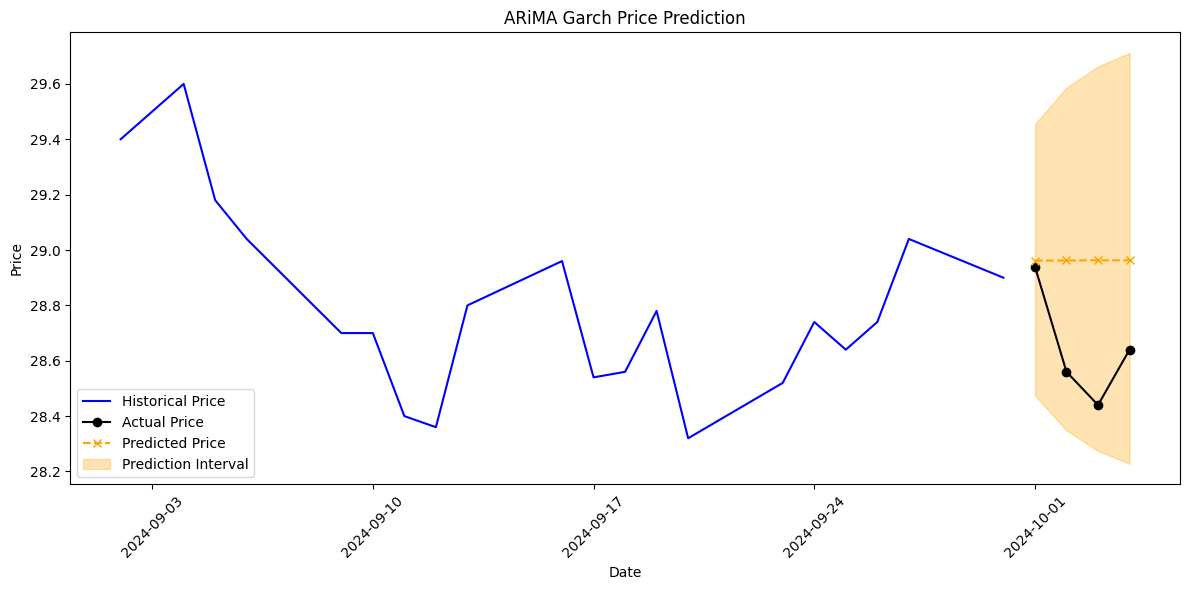

In [628]:
plot_price_prediction(forecast_AG_prices_df['Forecast'],forecast_AG_prices_df['Upper Bound'],forecast_AG_prices_df['Lower Bound'], 'ARiMA Garch Price Prediction')

In [629]:
forecast_errors_AG = [forecast_AG_prices_df['Forecast'][i] - real_values["Zamkniecie"][i] for i in range(len(real_values))]

mae = np.mean(np.abs(forecast_errors_AG))
mse = np.mean(np.square(forecast_errors_AG))
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.317446792041018
Mean Squared Error (MSE): 0.1350096289045037
Root Mean Squared Error (RMSE): 0.36743656446317874


# 6.4 monte carlo 

In [630]:
model_log = ARIMA(df['Logarytm ceny'], order=(1, 1, 0)).fit()

steps = 4 
n_simulations = 1000  

residuals = model_log.resid

forecast_results = []
current_data = df['Logarytm ceny'].copy()

for step in range(steps):
    model_log = ARIMA(current_data, order=(1, 1, 0)).fit()

    forecast = model_log.get_forecast(steps=1)
    point_forecast = forecast.predicted_mean.iloc[0]

    simulated_forecasts = np.zeros(n_simulations)

    for i in range(n_simulations):
        simulated_forecasts[i] = point_forecast + np.random.choice(residuals)

    lower_bound = np.percentile(simulated_forecasts, 2.5)
    upper_bound = np.percentile(simulated_forecasts, 97.5)

    forecast_results.append({
        'Point Forecast': point_forecast,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    })

    current_data = pd.concat([current_data, pd.Series([point_forecast])], ignore_index=True)

forecast_monte_carlo_df = pd.DataFrame(forecast_results)
print(forecast_monte_carlo_df)



   Point Forecast  Lower Bound  Upper Bound
0        3.365094     3.348891     3.391290
1        3.364769     3.342092     3.390965
2        3.364854     3.349094     3.390731
3        3.364832     3.346726     3.388506


In [631]:
sd_AG = (forecast_monte_carlo_df['Point Forecast'] - forecast_monte_carlo_df['Lower Bound']) / u_alpha
forecast_monte_carlo_AG_prices = np.exp(forecast_monte_carlo_df['Point Forecast'] + 0.5 * sd_AG**2)
forecast_monte_carlo_AG_prices_df = pd.DataFrame(forecast_monte_carlo_AG_prices, columns=['Point Forecast'])
forecast_monte_carlo_AG_prices_df[['Lower Bound', 'Upper Bound']] = np.exp(forecast_monte_carlo_df[['Lower Bound', 'Upper Bound']])
forecast_monte_carlo_AG_prices_df = forecast_monte_carlo_AG_prices_df.reset_index(drop=True)
print(forecast_monte_carlo_AG_prices_df)

   Point Forecast  Lower Bound  Upper Bound
0       28.937205    28.471137    29.704233
1       28.928763    28.278225    29.694594
2       28.930194    28.476922    29.687642
3       28.929863    28.409554    29.621670


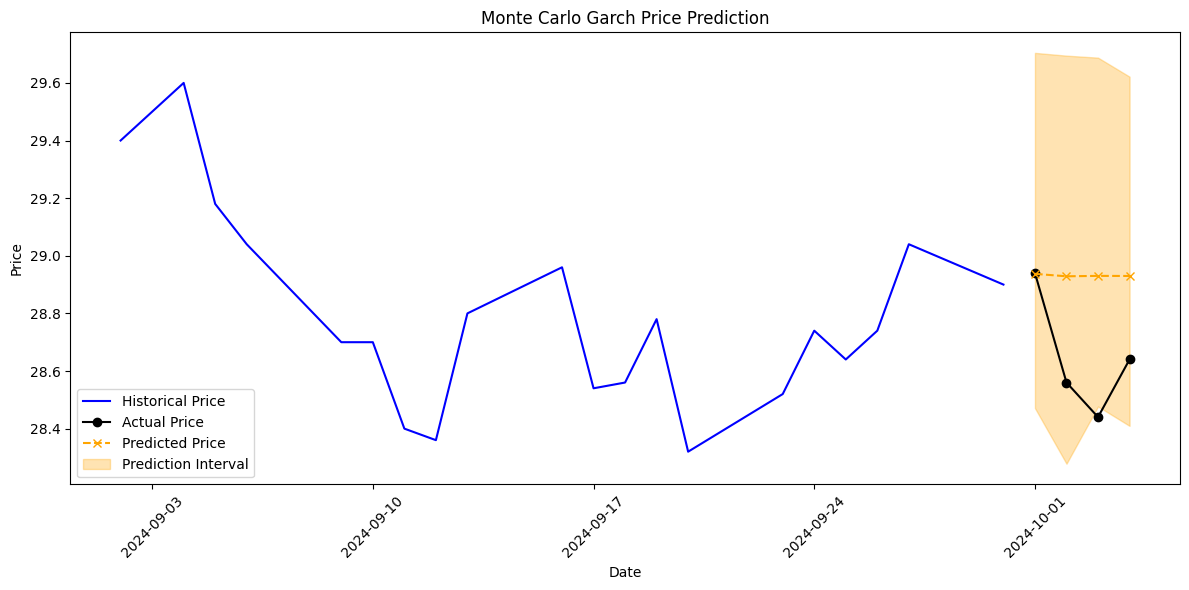

In [633]:
plot_price_prediction(forecast_monte_carlo_AG_prices_df['Point Forecast'],forecast_monte_carlo_AG_prices_df['Upper Bound'],forecast_monte_carlo_AG_prices_df['Lower Bound'], 'Monte Carlo Garch Price Prediction')

In [634]:
forecast_errors = [forecast_monte_carlo_AG_prices_df['Point Forecast'][i] - real_values["Zamkniecie"][i] for i in range(len(real_values))]

mae = np.mean(np.abs(forecast_errors))

mse = np.mean(np.square(forecast_errors))

rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.28790386463062223
Mean Squared Error (MSE): 0.11507623131054492
Root Mean Squared Error (RMSE): 0.3392288774714572


# 6.5 Bootstrap


In [635]:
np.random.seed(42)

forecast_results = []
current_data = df['Logarytm ceny'].copy()

for step in range(steps):
    model_log = ARIMA(current_data, order=(1, 1, 0)).fit()

    forecast = model_log.get_forecast(steps=1)
    point_forecast = forecast.predicted_mean.iloc[0]

    residuals = model_log.resid
    model_garch = arch_model(residuals, vol='Garch', p=1, q=1)
    garch_results = model_garch.fit(disp='off')

    garch_forecast = garch_results.forecast(horizon=1)
    garch_volatility = np.sqrt(garch_forecast.variance.values[-1, :][0])

    simulated_forecasts = np.zeros(n_simulations)

    for i in range(n_simulations):
        bootstrap_residual = np.random.choice(residuals, replace=True) * garch_volatility
        simulated_forecasts[i] = point_forecast + bootstrap_residual

    lower_bound = np.percentile(simulated_forecasts, 2.5)
    upper_bound = np.percentile(simulated_forecasts, 97.5)

    forecast_results.append({
        'Point Forecast': point_forecast,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    })

    current_data = pd.concat([current_data, pd.Series([point_forecast])], ignore_index=True)

forecast_bootstrap_df = pd.DataFrame(forecast_results)
print(forecast_bootstrap_df)

   Point Forecast  Lower Bound  Upper Bound
0        3.365094     3.364954     3.365320
1        3.364769     3.364064     3.365557
2        3.364854     3.363701     3.366642
3        3.364832     3.364170     3.365888


In [636]:
sd_AG_bs = (forecast_bootstrap_df['Point Forecast'] - forecast_bootstrap_df['Lower Bound']) / u_alpha

forecast_AG_bs_prices = np.exp(forecast_bootstrap_df['Point Forecast'] + 0.5 * sd_AG_bs ** 2)
forecast_AG_bs_prices_df = pd.DataFrame(forecast_AG_bs_prices, columns=['Forecast'])

forecast_AG_bs_prices_df[['Lower Bound', 'Upper Bound']] = np.exp(forecast_bootstrap_df[['Lower Bound', 'Upper Bound']])

forecast_AG_bs_prices_df = forecast_AG_bs_prices_df.reset_index(drop=True)

print(forecast_AG_bs_prices_df)

    Forecast  Lower Bound  Upper Bound
0  28.936216    28.932166    28.942764
1  28.926828    28.906432    28.949611
2  28.929264    28.895935    28.981050
3  28.928630    28.909501    28.959202


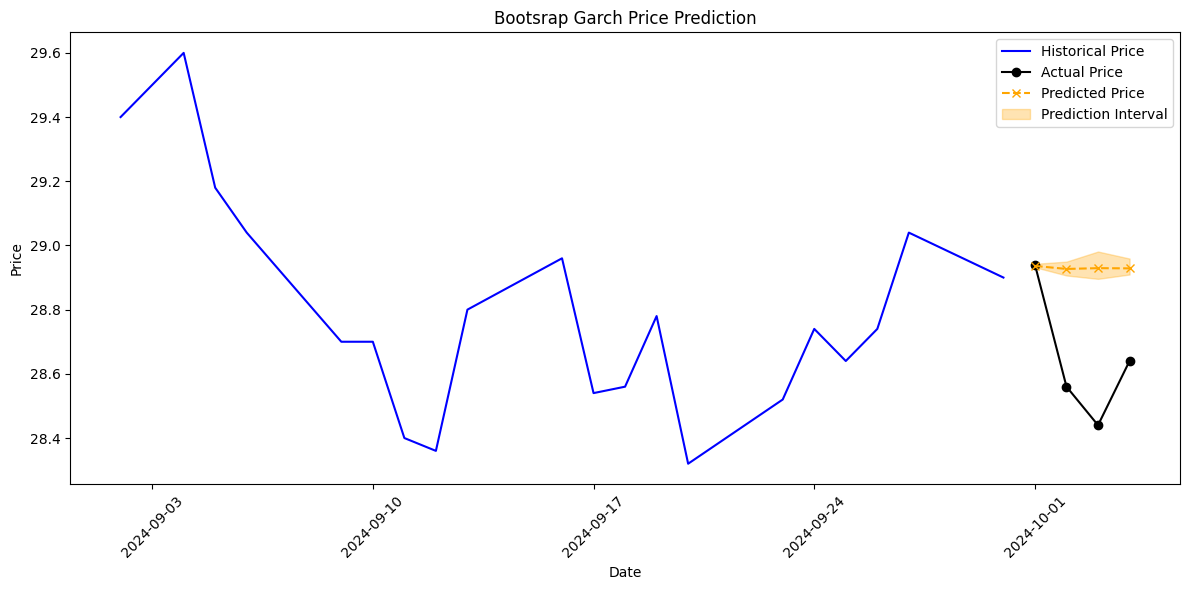

In [637]:
plot_price_prediction(forecast_AG_bs_prices_df['Forecast'],forecast_AG_bs_prices_df['Upper Bound'],forecast_AG_bs_prices_df['Lower Bound'], 'Bootsrap Garch Price Prediction')

In [638]:
forecast_errors = [forecast_AG_bs_prices_df['Forecast'][i] - real_values["Zamkniecie"][i] for i in range(len(real_values))]

mae = np.mean(np.abs(forecast_errors))

mse = np.mean(np.square(forecast_errors))

rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.28712670204237156
Mean Squared Error (MSE): 0.1143160599953649
Root Mean Squared Error (RMSE): 0.33810658082232725
